In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as ani
%matplotlib inline

In [2]:
# fname_in = './Patrick_test_2.csv'
# fname_in = './Patrick_test_3.csv'
fname_in = './Patrick_test_4_BodiTrak.csv'

In [3]:
isBodiTrak = 'BodiTrak' in fname_in
isBodiTrak

True

In [4]:
fname_in_filtered = fname_in.replace('.csv','_filtered.csv')
fname_in_filtered

'./Patrick_test_4_BodiTrak_filtered.csv'

In [5]:
if os.path.exists(fname_in_filtered):
    print('Filtered data exists; loading df_dat from {}...'.format(fname_in_filtered))
    df_dat = pd.read_csv(fname_in_filtered, index_col=0)
else:
    print('Filtered data does not exist; creating {}...'.format(fname_in_filtered))
    if isBodiTrak:
        df = pd.read_csv(fname_in, header=None, low_memory=False)
        df_dat_T = df.T
        df_dat = df_dat_T[df_dat_T.columns[-1024:]].iloc[1:].reset_index().drop('index', axis=1)
    else:
        df = pd.read_csv(fname_in, header=None)
        df_dat = df[df.columns[3:]]
    df_dat.to_csv(fname_in_filtered)
print('Done.')

Filtered data exists; loading df_dat from ./Patrick_test_4_BodiTrak_filtered.csv...
Done.


In [6]:
# df_dat.head()

In [7]:
xs = range(32)
ys = range(32)

In [8]:
x, y = np.meshgrid(xs, ys)
x_flat = x.flatten()
y_flat = y.flatten()

In [9]:
pad = 6

In [10]:
cmap = {
    0: '#e41a1c',
    1: '#ff7f00',
    2: '#4daf4a',
}

In [11]:
list_gridColors = []
for _ in range(pad):
    list_gridColors.append( [cmap[0]] * len(xs) )
for _ in range(pad):
    list_gridColors.append( [cmap[0]] * pad + [cmap[1]] * (len(xs)-2*pad) + [cmap[0]] * pad )
for _ in range(len(ys) - 4*pad):
    list_gridColors.append( [cmap[0]] * pad + [cmap[1]] * pad + [cmap[2]] * (len(xs)-4*pad) + [cmap[1]] * pad + [cmap[0]] * pad )
for _ in range(pad):
    list_gridColors.append( [cmap[0]] * pad + [cmap[1]] * (len(xs)-2*pad) + [cmap[0]] * pad )
for _ in range(pad):
    list_gridColors.append( [cmap[0]] * len(xs) )

In [12]:
arr_gridColors = np.asarray(list_gridColors)
arr_gridColors_flat = arr_gridColors.flatten()

In [13]:
# Set up for perc trackers.

In [14]:
list_gridRed = []
list_gridYellow = []
list_gridGreen = []

# bottom rows are only 'red'
for _ in range(pad):
    list_gridRed.append( [1] * len(xs) )
    list_gridYellow.append( [0] * len(xs) )
    list_gridGreen.append( [0] * len(xs) )

# lower rows are 'red' on outside, 'yellow' on inside
for _ in range(pad):
    list_gridRed.append( [1] * pad + [0] * (len(xs)-2*pad) + [1] * pad )
    list_gridYellow.append( [0] * pad + [1] * (len(xs)-2*pad) + [0] * pad )
    list_gridGreen.append( [0] * pad + [0] * (len(xs)-2*pad) + [0] * pad )

# middle rows are 'red' on outside, 'yellow' in middle, 'green' on inside
for _ in range(len(ys) - 4*pad):
    list_gridRed.append( [1] * pad + [0] * pad + [0] * (len(xs)-4*pad) + [0] * pad + [1] * pad )
    list_gridYellow.append( [0] * pad + [1] * pad + [0] * (len(xs)-4*pad) + [1] * pad + [0] * pad )
    list_gridGreen.append( [0] * pad + [0] * pad + [1] * (len(xs)-4*pad) + [0] * pad + [0] * pad )

# upper rows are 'red' on outside, 'yellow' on inside
for _ in range(pad):
    list_gridRed.append( [1] * pad + [0] * (len(xs)-2*pad) + [1] * pad )
    list_gridYellow.append( [0] * pad + [1] * (len(xs)-2*pad) + [0] * pad )
    list_gridGreen.append( [0] * pad + [0] * (len(xs)-2*pad) + [0] * pad )

# top rows are only 'red'
for _ in range(pad):
    list_gridRed.append( [1] * len(xs) )
    list_gridYellow.append( [0] * len(xs) )
    list_gridGreen.append( [0] * len(xs) )

In [15]:
arr_gridRed = np.asarray(list_gridRed)
arr_gridYellow = np.asarray(list_gridYellow)
arr_gridGreen = np.asarray(list_gridGreen)

In [16]:
arr_gridRed_flat = arr_gridRed.flatten()
arr_gridYellow_flat = arr_gridYellow.flatten()
arr_gridGreen_flat = arr_gridGreen.flatten()

In [17]:
# input video/CSV written at 30 FPS
# output video written at...
# 15 fps -> read every other frame
# 10 fps -> read every third frame

In [18]:
def shift_and_zero_left(arr, shift, default_value=0):
    arr_shifted = np.ones_like(arr) * default_value
    if shift < 32:
        arr_shifted[:, shift:] = arr[:, :-shift]
    else:
        arr_shifted[:, shift % 32:] = arr[:, :-shift % 32]
    return arr_shifted

In [19]:
def get_perc_overlap(arr1, arr2):
    # arr1 is ''subset'' of arr2
    if np.sum(arr2) > 0:
        return np.sum(np.logical_and(arr1, arr2)) / np.sum(arr2)
    else:
        return 0

In [20]:
def get_cm(arr):
    
    # Calculate total mass (sum of all elements in the array)
    total_mass = np.sum(arr)
    
    # Calculate indices along each axis
    [row_indices, col_indices] = np.indices(arr.shape)

    if total_mass == 0.0:
        return [(x/2) for x in arr.shape]
    
    # Calculate center of mass along each axis
    cm_x = np.sum(col_indices * arr) / total_mass
    cm_y = np.sum(row_indices * arr) / total_mass
    
    return [cm_x, cm_y]

In [21]:
def is_too_close_to_edge(arr, x, y, threshold=pad):
    h, w = arr.shape
    if x < threshold or x >= w - threshold or y < threshold or y >= h - threshold:
        return True
    else:
        return False

In [22]:
shifting = True

In [31]:
i = 0
i2arrs = {}
if not isBodiTrak: # TekScan sensor
    for fnum, row in df_dat.iterrows():
        if fnum % 3 == 0:
           
            arr_pressure = np.reshape( np.asarray( [float(e) for e in row.values] ), (32,32))
            
            pressureCond = arr_pressure > 0

            arr_mask = (pressureCond).astype(np.uint8) # either 0 or 1
            arr_s = np.where(pressureCond, arr_pressure, 1) # either <pressure> or 1, depending on mask
            arr_alpha = np.where(pressureCond, 1, 0.75) # either 1 or 0.75,, depending on mask

            # flip arrays from df_dat to get to right-side-up (rsu)
            arr_mask_rsu = np.fliplr(arr_mask)
            arr_s_rsu = np.fliplr(arr_s)
            arr_alpha_rsu = np.fliplr(arr_alpha)

            # get center of masses for arr_s
            (cm_x_press, cm_y_press) = get_cm(arr_s_rsu - 1) # -1 to adjust for s=1 requirement earlier
            
            percRed, percYellow, percGreen = [
                get_perc_overlap(grid_arr_col, arr_mask_rsu) for grid_arr_col in 
                [arr_gridRed, arr_gridYellow, arr_gridGreen]
            ]
            
            i2arrs[i] = [
                arr_mask_rsu, arr_s_rsu, arr_alpha_rsu, 
                percRed, 
                cm_x_press, cm_y_press
            ]
            i += 1
            
else: # BodiTrak sensor
    for fnum, row in df_dat.iterrows():
        if fnum % 3 == 0:
            
            arr_pressure = np.reshape( np.asarray( [float(e) for e in row.values] ), (32,32))
            pressureCond = arr_pressure > 0
            
            arr_mask = (pressureCond).astype(np.uint8)
            arr_s = np.where(pressureCond, arr_pressure, 1)
            arr_alpha = np.where(pressureCond, 1, 0.75)

            # flip arrays from df_dat to get to right-side-up (rsu)
            arr_mask_rsu = np.rot90(arr_mask, 2) # either 0 or 1
            arr_s_rsu = np.rot90(arr_s, 2)
            arr_alpha_rsu = np.rot90(arr_alpha, 2)

            # get center of masses for arr_s
            (cm_x_press, cm_y_press) = get_cm(arr_s_rsu - 1) # -1 to adjust for s=1 requirement earlier
            
            if shifting:
                shift = int(fnum / 360)
                if shift > 0:
                    arr_mask_rsu = shift_and_zero_left(arr_mask_rsu, shift) # either 0 or 1
                    arr_s_rsu = shift_and_zero_left(arr_s_rsu, shift, 0.75)
                    arr_alpha_rsu = shift_and_zero_left(arr_alpha_rsu, shift, 1)
                    cm_x_press += shift

            percRed, percYellow, percGreen = [
                get_perc_overlap(grid_arr_col, arr_mask_rsu) for grid_arr_col in 
                [arr_gridRed, arr_gridYellow, arr_gridGreen]
            ]

            # print(fnum, percRed)
            
            i2arrs[i] = [
                arr_mask_rsu, arr_s_rsu, arr_alpha_rsu, 
                percRed,
                cm_x_press, cm_y_press
            ]
            i += 1

In [24]:
len(i2arrs)

1367

In [25]:
# sns.heatmap(i2arrs[500][0])
# sns.heatmap(i2arrs[500][1])
# sns.heatmap(i2arrs[500][2])
# plt.show()

In [26]:
#plt.figure(figsize=(6, 6))
#plt.scatter(x_flat, y_flat, # x,y come from mat (FIXED)
#            c=grid_arr_red, # color depends on position (FIXED)
#            s=1,
#            marker='o')
#plt.show()

In [27]:
# i goes from 0-299 for frames 0-899
# so three real frames pass for each increment of i
# 2 seconds at 30 fps corresponds to 60 frames, i would range from 0 -> 19 (20 consecutive i's with "bad" conditions to raise alert)

durationBadStreak = 0
i2durationBadStreak = {}

i2too_close_to_edge = {}
i2raiseAlarm = {}

for i, arr in i2arrs.items(): 
    
    bool_is_too_close_to_edge = is_too_close_to_edge( arr[0], arr[-2], arr[-1] )

    if bool_is_too_close_to_edge:
        durationBadStreak += 1
        if durationBadStreak >= 20:
            i2raiseAlarm[i] = True
        else:
            i2raiseAlarm[i] = False
    else:
        durationBadStreak = 0
        i2raiseAlarm[i] = False
    
    i2too_close_to_edge[i] = bool_is_too_close_to_edge
    i2durationBadStreak[i] = durationBadStreak

#    [arr_mask_rsu, arr_s_rsu, arr_alpha_rsu, percRed] = i2arrs[i]
#    if percRed > 0.2:
#        tracker_percRed += 1
#    else:
#        print(f'Streak of {tracker_percRed} broken at {i}; resetting...')
#        tracker_percRed = 0

In [28]:
i2raiseAlarm

{0: False,
 1: False,
 2: False,
 3: False,
 4: False,
 5: False,
 6: False,
 7: False,
 8: False,
 9: False,
 10: False,
 11: False,
 12: False,
 13: False,
 14: False,
 15: False,
 16: False,
 17: False,
 18: False,
 19: False,
 20: False,
 21: False,
 22: False,
 23: False,
 24: False,
 25: False,
 26: False,
 27: False,
 28: False,
 29: False,
 30: False,
 31: False,
 32: False,
 33: False,
 34: False,
 35: False,
 36: False,
 37: False,
 38: False,
 39: False,
 40: False,
 41: False,
 42: False,
 43: False,
 44: False,
 45: False,
 46: False,
 47: False,
 48: False,
 49: False,
 50: False,
 51: False,
 52: False,
 53: False,
 54: False,
 55: False,
 56: False,
 57: False,
 58: False,
 59: False,
 60: False,
 61: False,
 62: False,
 63: False,
 64: False,
 65: False,
 66: False,
 67: False,
 68: False,
 69: False,
 70: False,
 71: False,
 72: False,
 73: False,
 74: False,
 75: False,
 76: False,
 77: False,
 78: False,
 79: False,
 80: False,
 81: False,
 82: False,
 83: False,
 8

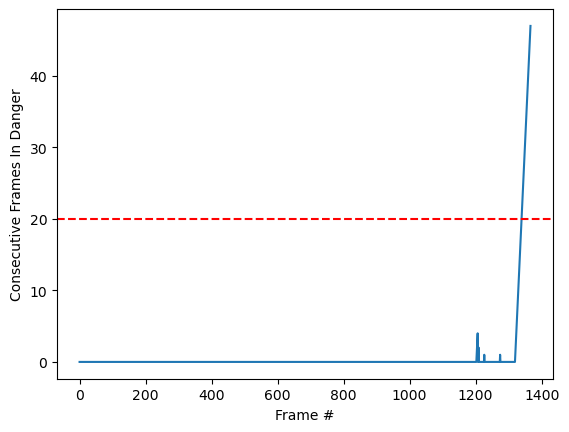

In [29]:
sns.lineplot(x=i2durationBadStreak.keys(), 
            y=i2durationBadStreak.values())
plt.axhline(y=20, color='r', linestyle='--')
plt.xlabel('Frame #')
plt.ylabel('Consecutive Frames In Danger')
plt.savefig('./graphical_representation.pdf')
plt.show()

Done.


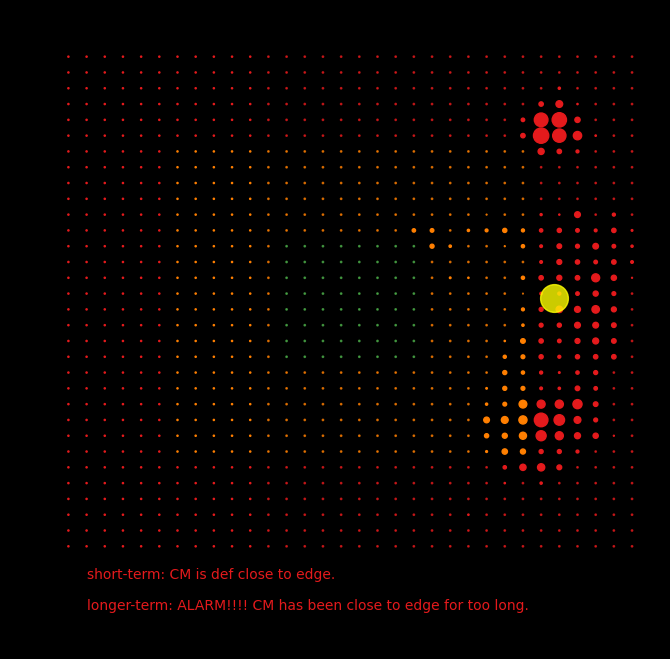

In [30]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='black')

ax.set_facecolor('black')
ax.set_ylim(-5, 34)

sc = ax.scatter(x_flat, y_flat, 
                c=arr_gridColors_flat, # x,y,color depends on position (FIXED)
                s=i2arrs[0][1].flatten(), # size depends on pressure (DYNAMIC) - use 0th frame 
                alpha=i2arrs[0][2].flatten(), # alpha depends on pressure > 0 (DYNAMIC) - use 0th frame
                marker='o')

cm_press, = ax.plot( [i2arrs[0][-2]], [i2arrs[0][-1]], marker='o', color='yellow', alpha=0.8, markersize=20)

text1 = ax.text( 1, -2, 'short-term: CM is {} close to edge.'.format( 'def' if i2too_close_to_edge[0] else 'not' ))
text2 = ax.text( 1, -4, 'longer-term: CM has not been close to edge for too long.', color='white')

# Function to update the scatter plot
def update(i):
    
    s = i2arrs[i][1].flatten()
    alpha = i2arrs[i][2].flatten()
    sc.set_sizes(s)
    sc.set_alpha(alpha)
    
    cm_press.set_data( [i2arrs[i][-2]], [i2arrs[i][-1]] )

    text1.set_text( 'short-term: CM is {} close to edge.'.format( 'def' if i2too_close_to_edge[i] else 'not' ) )
    if i2too_close_to_edge[i] == True:
        text1.set_color( '#e41a1c' )
    else:
        text1.set_color( 'white' )

    if i2raiseAlarm[i] == True:
        text2.set_color('#e41a1c')
        text2.set_text( 'longer-term: ALARM!!!! CM has been close to edge for too long.' )
    else:
        text2.set_color('white')
        text2.set_text( 'longer-term: CM has not been close to edge for too long.' )
    return sc, cm_press, text1, text2

# Create animation
animation = ani.FuncAnimation(fig, update, frames=len(i2arrs), interval=100, blit=True)

# Save the animation
fname_out = fname_in.replace('.csv', '.mp4')
animation.save(fname_out)
print('Done.')